# Code zu der Bachelorarbeit:
# "Comparitve Study von Machine Learning Modellen zur Erkennung von Web Schwachstellen"
## von Nils Pudenz, 2735230

## Imports

In [31]:

#%pip install kaggle scikit-learn xgboost catboost tabpfn pandas numpy matplotlib seaborn -q
#%pip install --quiet scikit-learn xgboost catboost tabpfn chardet
#%pip install -U scikit-learn
## in deiner (Conda/venv) Umgebung
#%pip install --upgrade "torch==2.*" --index-url https://download.pytorch.org/whl/cu121
#%pip install --upgrade xgboost catboost scikit-learn pandas scipy tabpfn
##wenn es komplikationen mit torch gibt, deiinstallieren und neu installieren
#%pip uninstall torch
#%pip install torch --index-url https://download.pytorch.org/whl/cu121 --upgrade
#%pip install openpyxl
#%pip install XlsxWriter
#%pip install openpyxl


In [32]:
import os, math, time
import numpy as np
import pandas as pd
import torch

import zipfile
import random
from pathlib import Path
import matplotlib.pyplot as plt
import joblib
import sys

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from tabpfn import TabPFNClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline


from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV


## Check ob GPU verwendet werden kann

In [33]:
print(sys.version)
print("CUDA verfügbar:", torch.cuda.is_available())

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
CUDA verfügbar: True


In [34]:
print("Python:", sys.executable)
print("Torch:", torch.__version__, "| CUDA build:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

Python: c:\Users\nilsp\Github_Desktop\Comparative_Study_ML_WebVuln\.venv\Scripts\python.exe
Torch: 2.5.1+cu121 | CUDA build: 12.1
CUDA available: True


In [35]:
def predict_in_batches(model, X, batch_size=512): #um Überlastung zu vermeiden, evtl. 256 oder 128
    """Make predictions on input data in batches."""
    preds = []
    for i in range(0, X.shape[0], batch_size):
        batch = X[i:i + batch_size]
        preds.append(model.predict(batch))
    return np.concatenate(preds)


## Dowload Kaggle Datasets
Requires Kaggle API credentials ('~/.kaggle/kaggle.json') für API-Token, um zugriff auf die Datenbanken über das Kaggle Konto zu bekommen

In [36]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

In [37]:
#Dowload der Datasets von Kaggle, Output =1 erfoglgreich, Output = 0 fehlerhaft
os.system("kaggle datasets download -d syedsaqlainhussain/sql-injection-dataset -p data --unzip --quiet")
os.system("kaggle datasets download -d syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning -p data --unzip --quiet")
#KAGGLE_DATASETS = { #gleich wie oben nur renaming auf sql & xss
#    "sql": "syedsaqlainhussain/sql-injection-dataset",
#    "xss": "syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning"
#}

0

In [38]:
def kaggle_download(dataset, path="data", unzip=True):
    api = KaggleApi()
    api.authenticate() #nutzt ~/.kaggle/kaggle.json für Authentifizierung oder Environment-Variablen
    api.dataset_download_files(dataset, path=path, unzip=unzip)
    print(f"Downloaded {dataset}")

kaggle_download("syedsaqlainhussain/sql-injection-dataset")#, path=DATA_DIR, unzip=True)
kaggle_download("syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning")#, path=DATA_DIR, unzip=True)
    

Dataset URL: https://www.kaggle.com/datasets/syedsaqlainhussain/sql-injection-dataset
Downloaded syedsaqlainhussain/sql-injection-dataset
Dataset URL: https://www.kaggle.com/datasets/syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning
Downloaded syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning


In [39]:

sql_df = pd.read_csv("data/SQLiV3.csv", encoding="utf-8", low_memory=False)
xss_df = pd.read_csv("data/XSS_dataset.csv", encoding="utf-8", low_memory=False)

In [40]:
# Spalten ansehen
print(sql_df.columns.tolist())

# Typische Index-/Hilfsspalten loswerden
sql_df = sql_df.loc[:, ~sql_df.columns.str.contains(r"^Unnamed|^index$", case=False)]

# Auf die Kernspalten reduzieren (falls etwas anderes drin ist)
sql_df = sql_df[["Sentence", "Label"]].copy()

# Optional: Duplikate auf Satzebene entfernen (falls noch nicht passiert)
sql_df = sql_df.drop_duplicates(subset=["Sentence"]).reset_index(drop=True)

print("clean shape:", sql_df.shape)  # Erwartung: (30873, 2)
print(sql_df["Label"].value_counts(normalize=True))


['Sentence', 'Label', 'Unnamed: 2', 'Unnamed: 3']
clean shape: (30873, 2)
Label
0                                                                         0.628891
1                                                                         0.370162
 --                                                                       0.000359
waitfor delay '0:0:__TIME__'--                                            0.000131
 DROP TABLE Suppliers                                                     0.000065
 desc users                                                               0.000033
SELECT *                                                                  0.000033
 OR                                                                       0.000033
 if not  (  select system_user  )   <> 'sa' waitfor delay '0:0:2' --      0.000033
 drop table temp --                                                       0.000033
 grant resource to name                                                   0.000033
 /*Sele

In [41]:

for name, df in {"SQL": sql_df, "XSS": xss_df}.items():
    print(f"{name} dataset shape: {df.shape}")
    display(df.head())
    display(df.describe())
    display(df.info())

SQL dataset shape: (30873, 2)


,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,NaN
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


,Sentence,Label
count,30872,30619
unique,30872,17
top,""" or pg_sleep ( __TIME__ ) --",0
freq,1,19256


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30873 entries, 0 to 30872
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30872 non-null  object
 1   Label     30619 non-null  object
dtypes: object(2)
memory usage: 482.5+ KB


None

XSS dataset shape: (13686, 3)


,Unnamed: 0,Sentence,Label
0,0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,2,"\t </span> <span class=""reference-text"">Steeri...",0
3,3,"\t </span> <span class=""reference-text""><cite ...",0
4,4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


,Unnamed: 0,Label
count,13686.000000,13686.000000
mean,6842.500000,0.538726
std,3950.952227,0.498516
min,0.000000,0.000000
25%,3421.250000,0.000000
50%,6842.500000,1.000000
75%,10263.750000,1.000000
max,13685.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13686 entries, 0 to 13685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13686 non-null  int64 
 1   Sentence    13686 non-null  object
 2   Label       13686 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 320.9+ KB


None

In [42]:
def class_distribution(df, label_col="Label"):
    """Zeigt die Klassenverteilung in einem DataFrame."""
    counts = df[label_col].value_counts(normalize=True)
    print("Klassenverteilung:")
    print(counts)
    plt.figure(figsize=(8, 4))
    counts.plot(kind="bar")
    plt.title("Klassenverteilung")
    plt.xlabel(label_col)
    plt.ylabel("Anteil")
    plt.xticks(rotation=0)
    plt.show()

    print("SQL Distribution:")
    print(class_distribution(sql_df, "Label"))

    print("XSS Distribution:")
    print(class_distribution(xss_df, "Label"))

## Basic Cleaning
* Drop Duplicate rows
* Handle missing values (simple fill-na)

In [43]:
for df in (sql_df, xss_df):
    df.drop_duplicates(inplace=True)
    df.fillna(0, inplace=True)

In [44]:
def preprocess_xy(df: pd.DataFrame,
                  label_candidates=("label", "class", "target"),
                  label_map=None):
    if label_map is None:
        label_map = {
            "0": "0", "1": "1",
            "benign": "0", "normal": "0", "legitimate": "0", "safe": "0",
            "attack": "1", "malicious": "1", "sql injection": "1",
            "sql-injection": "1", "xss": "1"
        }

    # Zielspalte finden (im *übergebenen* df!)
    cols_lower = {c.lower(): c for c in df.columns}
    target_col = next((cols_lower[c] for c in label_candidates if c in cols_lower), None)
    if target_col is None:
        raise ValueError(f"Keine Label-Spalte gefunden. Kandidaten: {label_candidates}")

    # Labels normieren -> nur 0/1 behalten
    y_str = df[target_col].astype(str).str.strip().str.lower()
    y_map = y_str.map(label_map)
    mask = y_map.notna()
    y = pd.to_numeric(y_map[mask]).astype(int).to_numpy()

    # Rohtext aus allen Nicht-Label-Spalten zusammenbauen
    feat_cols = [c for c in df.columns if c != target_col]
    X_raw = df.loc[mask, feat_cols].astype(str).agg(" ".join, axis=1)

    return X_raw, y, target_col


# Globale Settings

In [45]:

#Deterministische Ausgabe generieren, um die Reproduzierbarkeit zu gewährleisten
RANDOM_STATE = 42
#np.random.seed(RANDOM_STATE) wofür das?
#random.seed(RANDOM_STATE)
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
torch.set_num_threads(8)

USE_CUDA = torch.cuda.is_available()  # für TabPFN & XGBoost
print(f"[ENV] CUDA avail: {USE_CUDA} | Torch CUDA build: {torch.version.cuda}")


[ENV] CUDA avail: True | Torch CUDA build: 12.1


# Hilfsfunktionen 

## Evaluationsmetriken

In [46]:
def binary_metrics(y_true, y_pred) -> dict:
    """Präzision/Recall/F1 & Raten (FPR/FNR) für binäre Klassifikation."""
    y_pred = np.asarray(y_pred).ravel()
    p  = precision_score(y_true, y_pred)
    r  = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = float(fp / (fp + tn)) if (fp + tn) else 0.0
    fnr = float(fn / (fn + tp)) if (fn + tp) else 0.0
    return dict(Precision=p, Recall=r, F1=f1, FPR=fpr, FNR=fnr)

def evaluate_model(model, X_test, y_test, name, use_batches=False, batch_size=256) -> dict: #Dictionary für Evaluierungsmetriken
    """Zeitmessung + Vorhersage (optional in Batches) + Metriken."""
    print(f"→ Evaluate {name} on X_test={getattr(X_test,'shape',None)}")
    t0 = time.perf_counter()
    if use_batches:
        y_pred = predict_in_batches(model, X_test, batch_size=batch_size, verbose=True)
    else:
        y_pred = model.predict(X_test)
    pred_s = time.perf_counter() - t0
    m = binary_metrics(y_test, y_pred)
    res = dict(Model=name, Pred_s=pred_s, **m)
    return res

In [47]:
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """Zeigt eine Konfusionsmatrix an."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j], horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Preprocessing

### Batchweise Vorhersage für TabPFN

In [48]:
def predict_in_batches(model, X, batch_size=256, verbose=False):
    """Vorhersage in Batches (schont RAM/VRAM; wichtig für TabPFN)."""
    n = X.shape[0]
    out = []
    total = math.ceil(n / batch_size)
    for b, i in enumerate(range(0, n, batch_size), start=1):
        j = min(i + batch_size, n)
        t1 = time.perf_counter()
        with torch.inference_mode():
            out.append(model.predict(X[i:j]))
        dt = time.perf_counter() - t1
        if verbose:
            print(f"   [predict] batch {b:>3}/{total} ({j-i} rows) in {dt:.2f}s")
        if USE_CUDA:
            torch.cuda.synchronize()
    return np.concatenate(out)

### Label bereinigung der Datensets

In [49]:
def clean_labels(df, label_col="Label", text_cols=("Sentence",)):
    """Bringt Labels robust auf {0,1} und gibt (X_raw, y) zurück."""
    df = df.copy()
    
    # Labels in {0,1} umwandeln
    y_raw = df[label_col].astype(str).str.strip().str.lower()
    map01 = {
        "0": "0", "1": "1", "benign": "0", "normal": "0", "legitimate": "0", "safe": "0",
        "attack": "1", "malicious": "1", "sql injection": "1", "sql-injection": "1", "xss": "1"
    }
    y_map = y_raw.map(map01)
    mask = y_map.notna()
    y = pd.to_numeric(y_map[mask]).astype(int).to_numpy()
    
    # Explizit nur angegebene Textspalten verwenden!
    X_raw = df.loc[mask, text_cols].astype(str).agg(" ".join, axis=1)
    
    return X_raw, y

## Split

In [50]:
# Falls clean_labels(X) bereits (Rohtext, y) zurückgibt:
X_txt_sql, y_sql = clean_labels(sql_df, label_col="Label", text_cols=("Sentence",))
X_train_sql, X_test_sql, y_train_sql, y_test_sql = train_test_split(
    X_txt_sql, y_sql, test_size=0.2, stratify=y_sql, random_state=RANDOM_STATE
)

X_txt_xss, y_xss = clean_labels(xss_df, label_col="Label", text_cols=("Sentence",))
X_train_xss, X_test_xss, y_train_xss, y_test_xss = train_test_split(
    X_txt_xss, y_xss, test_size=0.2, stratify=y_xss, random_state=RANDOM_STATE
)

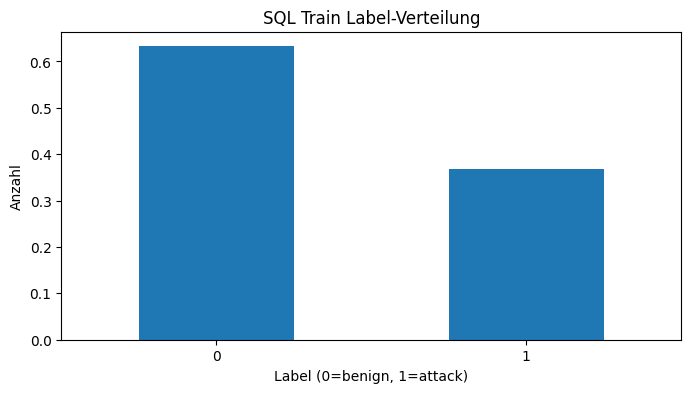

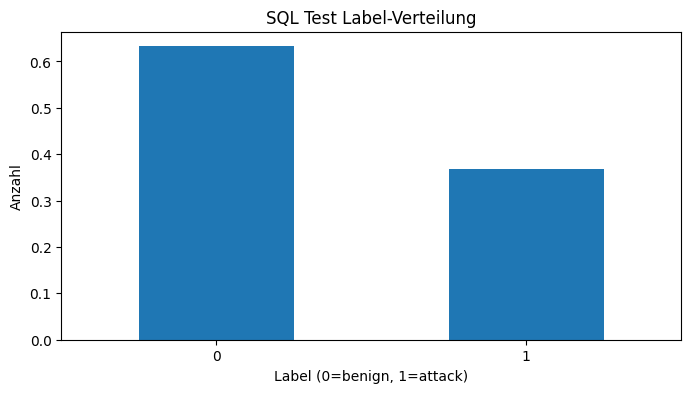

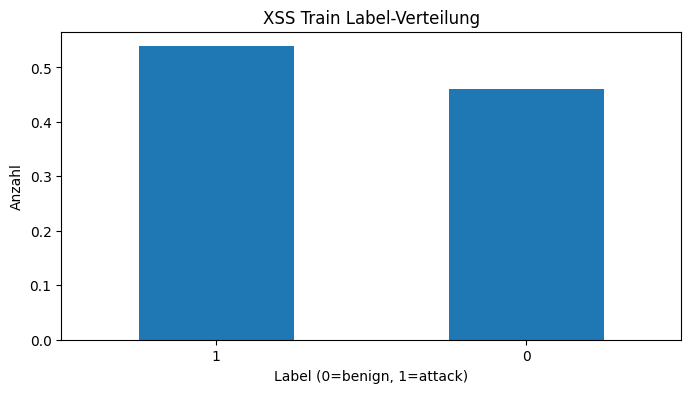

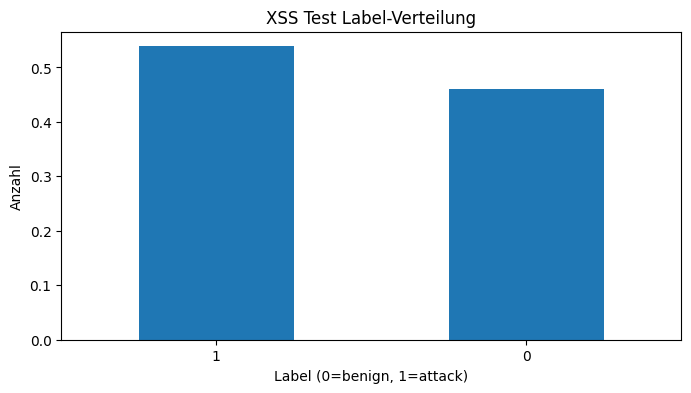

In [51]:
def plot_class_distribution(y, title="Label-Verteilung"):
    """Zeigt die Label-Verteilung in einem Balkendiagramm."""
    counts = pd.Series(y).value_counts(normalize=True)
    plt.figure(figsize=(8, 4))
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Label (0=benign, 1=attack)")
    plt.ylabel("Anzahl")
    plt.xticks(rotation=0)
    plt.show()

plot_class_distribution(y_train_sql, "SQL Train Label-Verteilung")
plot_class_distribution(y_test_sql, "SQL Test Label-Verteilung")

plot_class_distribution(y_train_xss, "XSS Train Label-Verteilung")
plot_class_distribution(y_test_xss, "XSS Test Label-Verteilung")

## Beispielzeilen für Benign und Malicious Zeilen

In [52]:
def example_lines(X, y, min_len=10):
    # Falls X ein DataFrame ist, versuche, die Textspalte zu finden
    if isinstance(X, pd.DataFrame):
        if "Sentence" in X.columns:
            X = X["Sentence"]
        else:
            raise ValueError("X ist ein DataFrame, aber enthält keine 'Sentence'-Spalte.")

    # Nun: Standardfilterung
    benigns = X[(y == 0) & (X.str.len() > min_len)]
    malicious = X[(y == 1) & (X.str.len() > min_len)]

    if len(benigns) == 0 or len(malicious) == 0:
        raise ValueError("Nicht genügend Beispiele für benign und malicious gefunden.")

    return benigns.iloc[0], malicious.iloc[0]

X_sql, y_sql = clean_labels(sql_df, label_col="Label", text_cols=("Sentence",))
sql_benign, sql_malicious = example_lines(X_sql, y_sql)

X_xss, y_xss = clean_labels(xss_df, label_col="Label", text_cols=("Sentence",))
xss_benign, xss_malicious = example_lines(X_xss, y_xss)

print("SQL Beispielhafte Zeilen vor Filter:", X_txt_sql.iloc[0])
print("XSS Beispielhafte Zeilen nach Filter:", X_txt_xss.iloc[0])

print("----------------------")

print("Beispiel für SQL-Injection:")

print("Benign:", sql_benign)
print("Malicious:", sql_malicious)

print("\nBeispiel für XSS:")

print("Benign:", xss_benign)
print("Malicious:", xss_malicious)

SQL Beispielhafte Zeilen vor Filter: " or pg_sleep  (  __TIME__  )  --
XSS Beispielhafte Zeilen nach Filter: <li><a href="/wiki/File:Socrates.png" class="image"><img alt="Socrates.png" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Socrates.png/18px-Socrates.png" decoding="async" width="18" height="28" class="noviewer" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Socrates.png/27px-Socrates.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Socrates.png/36px-Socrates.png 2x" data-file-width="326" data-file-height="500" /> </a> <a href="/wiki/Portal:Philosophy" title="Portal:Philosophy">Philosophy&#32;portal </a> </li> </ul>
----------------------
Beispiel für SQL-Injection:
Benign: create user name identified by pass123 temporary tablespace temp default tablespace users
Malicious: " or pg_sleep  (  __TIME__  )  --

Beispiel für XSS:
Benign: <li><a href="/wiki/File:Socrates.png" class="image"><img alt="Socrates.png" src="//upload.wikimedia.org/wikipedi

# Modelle

In [53]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    "MLP": MLPClassifier(hidden_layer_sizes=(256,128), activation="relu",
                         early_stopping=True, n_iter_no_change=5, max_iter=200,
                         random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.8,
        tree_method="hist", device=("cuda" if USE_CUDA else "cpu"),
        random_state=RANDOM_STATE
    ),
    "CatBoost": CatBoostClassifier(
        iterations=400, depth=8, learning_rate=0.1,
        loss_function="Logloss", random_seed=RANDOM_STATE, verbose=False,
        task_type="CPU"   # stabil über Pool + Sparse; bei GPU: task_type="GPU" und ggf. Dense verwenden
    ),
    "TabPFN": TabPFNClassifier(
        device=("cuda" if USE_CUDA else "cpu"),
        ignore_pretraining_limits=True
    )
}

# Pipeline

In [54]:
#TDF-IDF Einstellungen
#VEC_ARGS = dict(ngram_range=(3,5), max_features=50_000, sublinear_tf=True, lowercase=False)
VEC_ARGS = dict(analyzer="char", ngram_range=(3,5), min_df=3, max_features=50_000, sublinear_tf=True, lowercase=False, dtype=np.float32)


TABPFN_MAX_SAMPLES = 4000     # starte konservativ; später 6000/8000 testen
TABPFN_N_COMPONENTS = 150     # <=500, kleiner = schneller/ram-sparender
TABPFN_BATCH = 128            # Batch für Predict; 128/64 bei RAM-Engpässen

results = []



## Pipeline je Datensatz (TF-IDF; TabPFN: SVD + batched predict)

In [55]:
# ===== vorausgesetzt: deine fertigen Splits existieren =====
# X_train_sql, X_test_sql, y_train_sql, y_test_sql
# X_train_xss, X_test_xss, y_train_xss, y_test_xss

from sklearn.base import clone
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import Pool
import numpy as np, time, torch


splits = {
    "SQL": (X_train_sql, X_test_sql, y_train_sql, y_test_sql),
    "XSS": (X_train_xss, X_test_xss, y_train_xss, y_test_xss),
}

for ds_name, (X_train_txt, X_test_txt, y_train, y_test) in splits.items():
    print("\n" + "="*70)
    print(f"DATASET: {ds_name} | train={len(y_train)} test={len(y_test)} (pos_rate_train={np.mean(y_train):.3f})")

    #TF-IDF nur auf Train fitten (kein Leakage)
    vec = TfidfVectorizer(**VEC_ARGS)
    t0 = time.perf_counter()
    X_train_vec = vec.fit_transform(X_train_txt)
    #Feature anzeigen
    feature_names = vec.get_feature_names_out()
    print(f"TF-IDF Features: {len(feature_names)}")
    print("Beispiel-Feature:", feature_names[:10])  # Zeigt das
    X_test_vec  = vec.transform(X_test_txt)
    print(f"[VEC] TF-IDF train={X_train_vec.shape}, test={X_test_vec.shape} in {time.perf_counter()-t0:.2f}s")

    #Modelle trainieren/evaluieren (jeweils frischen Klon verwenden)
    for name, base_model in models.items():
        model = clone(base_model)
        print("-"*50 + f"\nMODEL: {name} on {ds_name}")

        if name == "CatBoost":
            # CatBoost: Pool nutzen (sparse ok)
            pool_train = Pool(X_train_vec, y_train)
            t0 = time.perf_counter()
            model.fit(pool_train)
            print(f"[{name}] fit in {time.perf_counter()-t0:.2f}s")

            # Test direkt auf X_test_vec (CatBoost kann CSR); alternativ: Pool(X_test_vec, y_test)
            res = evaluate_model(model, X_test_vec, y_test, f"{name}-{ds_name}")
            results.append(res)
            print(res)

        elif name == "TabPFN":
            # TabPFN: ggf. stratifiziertes Subset (Limits), danach SVD -> dichte float32
            X_tab, y_tab = X_train_vec, y_train
            if X_train_vec.shape[0] > TABPFN_MAX_SAMPLES:
                sss = StratifiedShuffleSplit(n_splits=1, train_size=TABPFN_MAX_SAMPLES, random_state=RANDOM_STATE)
                idx, _ = next(sss.split(np.zeros(len(y_train)), y_train))
                X_tab = X_train_vec[idx]
                y_tab = np.asarray(y_train)[idx]
            print(f"[{name}] train subset: {X_tab.shape[0]} rows")

            t0 = time.perf_counter()
            svd = TruncatedSVD(n_components=TABPFN_N_COMPONENTS, random_state=RANDOM_STATE)
            X_train_svd = svd.fit_transform(X_tab).astype("float32", copy=False)
            X_test_svd  = svd.transform(X_test_vec).astype("float32", copy=False)
            print(f"[{name}] SVD train={X_train_svd.shape}, test={X_test_svd.shape} in {time.perf_counter()-t0:.2f}s")

            # Gerät einstellen & fitten
            if hasattr(model, "set_params"):
                model.set_params(device=("cuda" if USE_CUDA else "cpu"), ignore_pretraining_limits=True)
            t0 = time.perf_counter()
            model.fit(X_train_svd, y_tab)
            if USE_CUDA:
                torch.cuda.synchronize()
            print(f"[{name}] fit in {time.perf_counter()-t0:.2f}s (device={'cuda' if USE_CUDA else 'cpu'})")

            # Evaluieren (wenn deine evaluate_model batched predict unterstützt, ansonsten normal)
            try:
                res = evaluate_model(model, X_test_svd, y_test, f"{name}-{ds_name}",
                                     use_batches=True, batch_size=TABPFN_BATCH)
            except TypeError:
                res = evaluate_model(model, X_test_svd, y_test, f"{name}-{ds_name}")
            results.append(res)
            print(res)

        else:
            # RF / MLP / XGBoost: direkt auf sparse TF-IDF
            t0 = time.perf_counter()
            model.fit(X_train_vec, y_train)
            print(f"[{name}] fit in {time.perf_counter()-t0:.2f}s")
            res = evaluate_model(model, X_test_vec, y_test, f"{name}-{ds_name}")
            results.append(res)
            print(res)




DATASET: SQL | train=24675 test=6169 (pos_rate_train=0.367)
TF-IDF Features: 50000
Beispiel-Feature: [' !<' ' !<@' ' " ' ' " (' ' " ( ' ' " )' ' " ) ' ' " o' ' " or' ' ""']
[VEC] TF-IDF train=(24675, 50000), test=(6169, 50000) in 3.93s
--------------------------------------------------
MODEL: RandomForest on SQL
[RandomForest] fit in 4.80s
→ Evaluate RandomForest-SQL on X_test=(6169, 50000)
{'Model': 'RandomForest-SQL', 'Pred_s': 0.19167390000075102, 'Precision': 0.9991083370485956, 'Recall': 0.9885310983678871, 'F1': 0.9937915742793791, 'FPR': 0.0005125576627370579, 'FNR': 0.011468901632112925}
--------------------------------------------------
MODEL: MLP on SQL
[MLP] fit in 254.68s
→ Evaluate MLP-SQL on X_test=(6169, 50000)
{'Model': 'MLP-SQL', 'Pred_s': 0.08696669999335427, 'Precision': 0.999553770638108, 'Recall': 0.9880899867666519, 'F1': 0.9937888198757764, 'FPR': 0.00025627883136852895, 'FNR': 0.011910013233348038}
--------------------------------------------------
MODEL: XGBoo

# Ergebnisse für Modelle

## Ergebnistabelle ausgeben

In [56]:
# Ergebnis-Tabelle ausgeben
df_results = pd.DataFrame(results)
display(df_results.sort_values(["Model"]).reset_index(drop=True))
df_results.to_csv("results_all.csv", index=False)
with pd.ExcelWriter("results_all.xlsx") as w:
    df_results.to_excel(w, sheet_name="All", index=False)
print(" Ergebnisse gespeichert: results_all.csv / results_all.xlsx")

,Model,Pred_s,Precision,Recall,F1,FPR,FNR
0,CatBoost-SQL,0.180626,0.999108,0.987649,0.993345,0.000513,0.012351
1,CatBoost-XSS,0.138714,1.000000,0.995254,0.997621,0.000000,0.004746
2,MLP-SQL,0.086967,0.999554,0.988090,0.993789,0.000256,0.011910
3,MLP-XSS,0.056769,1.000000,0.999322,0.999661,0.000000,0.000678
4,RandomForest-SQL,0.191674,0.999108,0.988531,0.993792,0.000513,0.011469
5,RandomForest-XSS,0.098393,1.000000,0.996610,0.998302,0.000000,0.003390
6,TabPFN-SQL,1308.625039,0.998662,0.987649,0.993125,0.000769,0.012351
7,TabPFN-XSS,586.418631,0.997961,0.995254,0.996606,0.002375,0.004746
8,XGBoost-SQL,0.023168,0.923264,0.668725,0.775646,0.032291,0.331275
9,XGBoost-XSS,0.030177,0.995035,0.951186,0.972617,0.005542,0.048814


 Ergebnisse gespeichert: results_all.csv / results_all.xlsx


## Ergebnisse speichern

## Ergebnistabelle

In [57]:
results_df = pd.DataFrame(results)
results_df.sort_values(["Model"], inplace=True)
print("\n Gesamt Ergebnisse: \n", results_df)

results_df.to_csv("results.csv", index=False)


 Gesamt Ergebnisse: 
               Model       Pred_s  Precision    Recall        F1       FPR  \
3      CatBoost-SQL     0.180626   0.999108  0.987649  0.993345  0.000513   
8      CatBoost-XSS     0.138714   1.000000  0.995254  0.997621  0.000000   
1           MLP-SQL     0.086967   0.999554  0.988090  0.993789  0.000256   
6           MLP-XSS     0.056769   1.000000  0.999322  0.999661  0.000000   
0  RandomForest-SQL     0.191674   0.999108  0.988531  0.993792  0.000513   
5  RandomForest-XSS     0.098393   1.000000  0.996610  0.998302  0.000000   
4        TabPFN-SQL  1308.625039   0.998662  0.987649  0.993125  0.000769   
9        TabPFN-XSS   586.418631   0.997961  0.995254  0.996606  0.002375   
2       XGBoost-SQL     0.023168   0.923264  0.668725  0.775646  0.032291   
7       XGBoost-XSS     0.030177   0.995035  0.951186  0.972617  0.005542   

        FNR  
3  0.012351  
8  0.004746  
1  0.011910  
6  0.000678  
0  0.011469  
5  0.003390  
4  0.012351  
9  0.004746  
2  

# Hyperparameter-Tuning & Cross-Validation

In [58]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import (
    HalvingRandomSearchCV, train_test_split, StratifiedKFold, StratifiedShuffleSplit, RandomizedSearchCV)
from joblib import Memory

## Feature und Modelle

In [59]:
# Feature-Builder (schnell & schlank)

def make_tfidf(max_features=20_000):
    return TfidfVectorizer(
        analyzer="char", ngram_range=(3,5),
        min_df=3, max_features=max_features,
        sublinear_tf=True, lowercase=False,
        dtype=np.float32
    )

# Cache, damit TF-IDF/SVD nicht in jedem Kandidaten neu gelernt werden müssen
memory = Memory(location="skcache", verbose=0)


#schlanke Suchräume
def pos_weight(y):
    pos = max(1, int(np.sum(y))); neg = max(1, int(len(y)-pos))
    return neg / pos

def grids(y):
    return {
        "RF": {
            "svd__n_components": [120, 150, 200],
            "clf__n_estimators": [300, 600],
            "clf__max_depth": [None, 20, 40],
            "clf__min_samples_split": [2, 5, 10],
            "clf__max_features": ["sqrt", None],
        },
        "MLP": {
            "svd__n_components": [120, 150, 200],
            "clf__hidden_layer_sizes": [(256,128), (512,256)],
            "clf__alpha": np.logspace(-5, -3, 3),
            "clf__learning_rate_init": [1e-4, 5e-4, 1e-3],
            "clf__batch_size": [64, 128],
        },
        "XGB": {
            "tfidf__max_features": [15_000, 20_000],
            "clf__n_estimators": [300, 500],
            "clf__max_depth": [4, 6, 8],
            "clf__learning_rate": [0.05, 0.1],
            "clf__subsample": [0.7, 1.0],
            "clf__colsample_bytree": [0.6, 1.0],
            "clf__reg_lambda": [0, 5],
            "clf__gamma": [0, 1],
            "clf__scale_pos_weight": [pos_weight(y)],
        },
        "CAT": {
            "tfidf__max_features": [15_000, 20_000],
            "clf__iterations": [400, 800],
            "clf__depth": [6, 8],
            "clf__learning_rate": [0.05, 0.1],
            "clf__l2_leaf_reg": [3, 5],
        }
    }


## Pipeline

In [60]:

def get_hpo_subset(X, y, n=8000):
    """Erzeugt ein stratifiziertes Subset für HPO."""
    if len(y) <= n:
        return X, y
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=RANDOM_STATE)
    idx, _ = next(sss.split(np.zeros(len(y)), y))
    if hasattr(X, "iloc"):  # DataFrame oder Series
        return X.iloc[idx], np.asarray(y)[idx]
    else:
        return X[idx], np.asarray(y)[idx]


In [61]:
def plot_results(results_df, title="Modellevaluation", metric="F1"):
    """Zeigt die Ergebnisse als Balkendiagramm an."""
    plt.figure(figsize=(12, 6))
    results_df.sort_values(by=metric, ascending=False).plot(
        x="Model", y=metric, kind="bar", legend=False, color="skyblue"
    )
    plt.title(title)
    plt.xlabel("Modelle")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [62]:
#Pipelines
def pipe_rf_svd(max_features=20_000, n_comp=150):
    return Pipeline([
        ("tfidf", make_tfidf(max_features)),
        ("svd", TruncatedSVD(n_components=n_comp, random_state=RANDOM_STATE)),
        ("clf", RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE))
    ], memory=memory)

def pipe_mlp_svd(max_features=20_000, n_comp=150):
    return Pipeline([
        ("tfidf", make_tfidf(max_features)),
        ("svd", TruncatedSVD(n_components=n_comp, random_state=RANDOM_STATE)),
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", MLPClassifier(
            early_stopping=True, n_iter_no_change=8, max_iter=200,
            random_state=RANDOM_STATE
        ))
    ], memory=memory)

def pipe_xgb_sparse(max_features=20_000):
    return Pipeline([
        ("tfidf", make_tfidf(max_features)),
        ("clf", XGBClassifier(
            tree_method="hist",
            device=("cuda" if USE_CUDA else "cpu"),
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=1  # Parallelisierung über CV, nicht im Estimator
        ))
    ], memory=memory)

def pipe_cat_sparse(max_features=20_000):
    return Pipeline([
        ("tfidf", make_tfidf(max_features)),
        ("clf", CatBoostClassifier(
            loss_function="Logloss",
            verbose=False,
            random_seed=RANDOM_STATE
        ))
    ], memory=memory)


TUNING: RandomForest (SQL)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 2 folds for each of 6 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[RF] best F1 (CV): 0.9907 in 0.5 min
[RF] best params: {'svd__n_components': 150, 'clf__n_estimators': 600, 'clf__min_samples_split': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None}


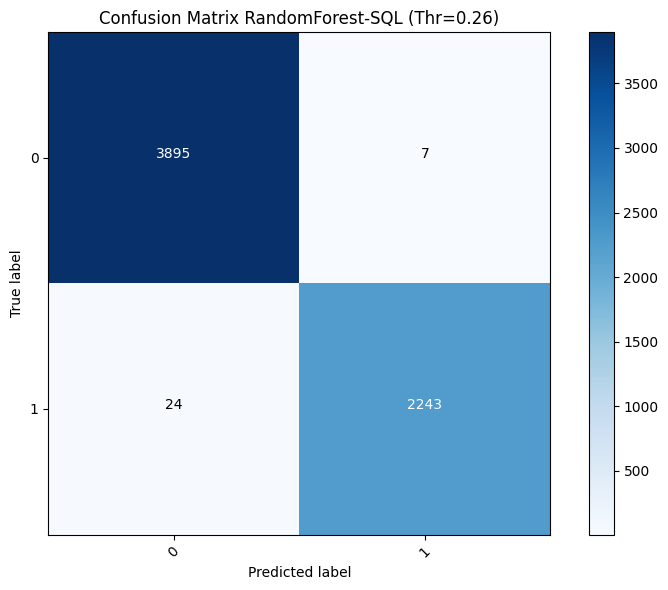

TEST: {'Model': 'RandomForest-SQL', 'Thr': 0.26, 'Precision': 0.9968888888888889, 'Recall': 0.9894133215703573, 'F1': 0.9931370378569847, 'FPR': 0.0017939518195797027, 'FNR': 0.0105866784296427}

TUNING: MLP (SQL)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 2 folds for each of 6 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[MLP] best F1 (CV): 0.9877 in 0.3 min
[MLP] best params: {'svd__n_components': 200, 'clf__learning_rate_init': 0.0001, 'clf__hidden_layer_sizes': (512, 256), 'clf__batch_size': 64, 'clf__alpha': np.float64(0.001)}


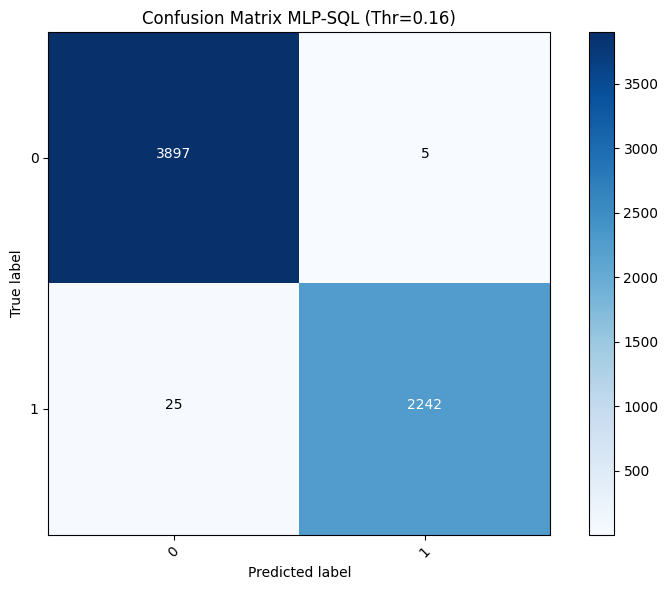

TEST: {'Model': 'MLP-SQL', 'Thr': 0.16, 'Precision': 0.9977748108589231, 'Recall': 0.9889722099691222, 'F1': 0.9933540097474524, 'FPR': 0.0012813941568426447, 'FNR': 0.011027790030877812}

TUNING: XGBoost (SQL)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 2 folds for each of 6 candidates, totalling 12 fits


c:\Users\nilsp\Github_Desktop\Comparative_Study_ML_WebVuln\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[XGB] best F1 (CV): 0.9571 in 1.6 min
[XGB] best params: {'tfidf__max_features': 15000, 'clf__subsample': 0.7, 'clf__scale_pos_weight': 1.7210884353741496, 'clf__reg_lambda': 5, 'clf__n_estimators': 300, 'clf__max_depth': 8, 'clf__learning_rate': 0.1, 'clf__gamma': 1, 'clf__colsample_bytree': 1.0}


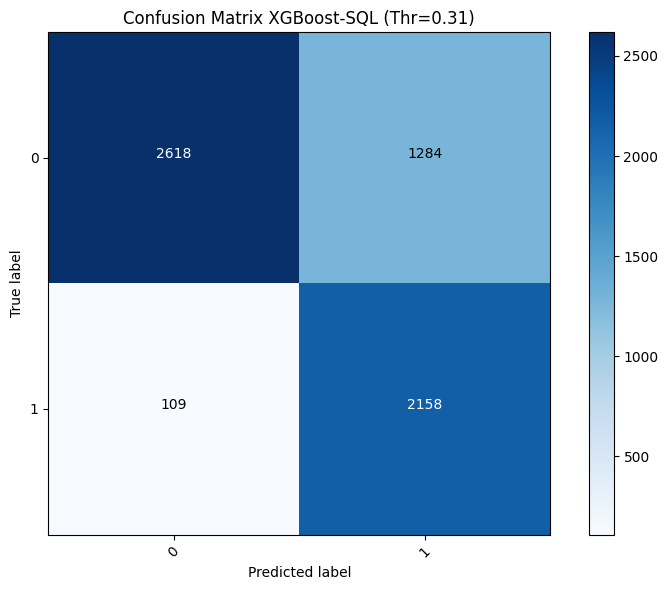

TEST: {'Model': 'XGBoost-SQL', 'Thr': 0.31, 'Precision': 0.6269610691458455, 'Recall': 0.9519188354653727, 'F1': 0.7559992993519005, 'FPR': 0.32906201947719116, 'FNR': 0.04808116453462726}

TUNING: CatBoost (SQL)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 2 folds for each of 6 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CAT] best F1 (CV): 0.9922 in 11.8 min
[CAT] best params: {'tfidf__max_features': 20000, 'clf__learning_rate': 0.1, 'clf__l2_leaf_reg': 5, 'clf__iterations': 800, 'clf__depth': 6}


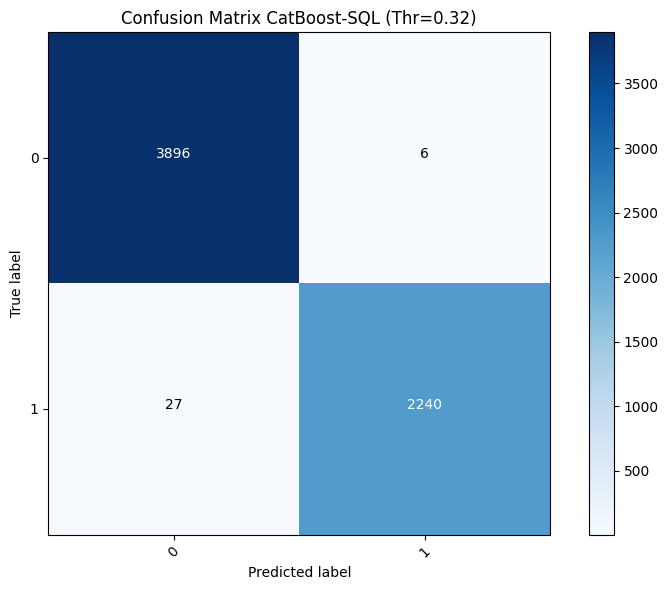

TEST: {'Model': 'CatBoost-SQL', 'Thr': 0.32, 'Precision': 0.9973285841495992, 'Recall': 0.9880899867666519, 'F1': 0.9926877908265013, 'FPR': 0.0015376729882111738, 'FNR': 0.011910013233348038}

TUNING: RandomForest (XSS)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 2 folds for each of 6 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[RF] best F1 (CV): 0.9914 in 0.6 min
[RF] best params: {'svd__n_components': 150, 'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__max_features': None, 'clf__max_depth': 20}


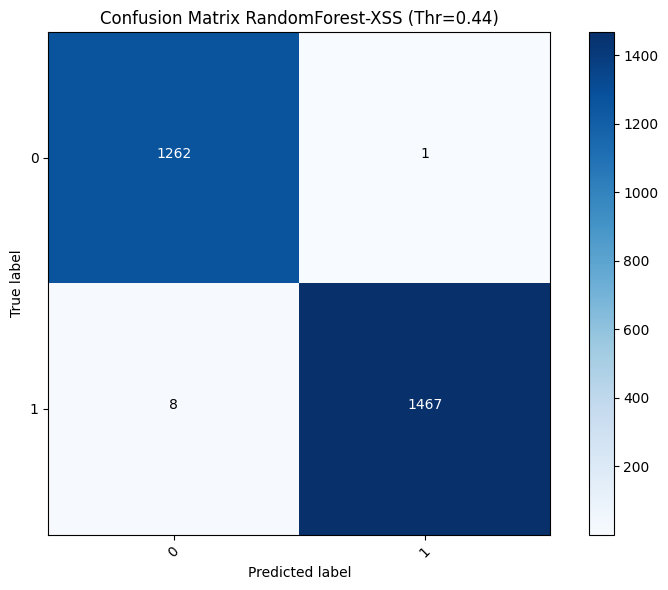

TEST: {'Model': 'RandomForest-XSS', 'Thr': 0.44000000000000006, 'Precision': 0.9993188010899182, 'Recall': 0.9945762711864407, 'F1': 0.9969418960244648, 'FPR': 0.000791765637371338, 'FNR': 0.005423728813559322}

TUNING: MLP (XSS)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 2 folds for each of 6 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[MLP] best F1 (CV): 0.9953 in 0.3 min
[MLP] best params: {'svd__n_components': 150, 'clf__learning_rate_init': 0.0005, 'clf__hidden_layer_sizes': (512, 256), 'clf__batch_size': 128, 'clf__alpha': np.float64(0.0001)}


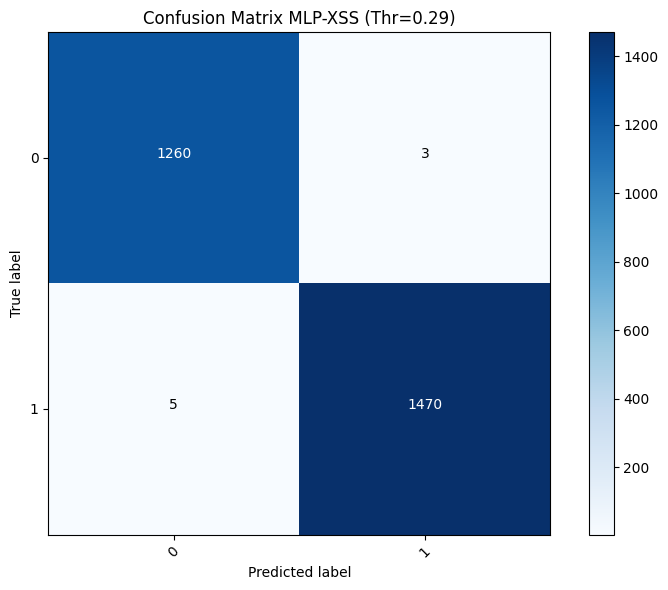

TEST: {'Model': 'MLP-XSS', 'Thr': 0.29000000000000004, 'Precision': 0.9979633401221996, 'Recall': 0.9966101694915255, 'F1': 0.9972862957937585, 'FPR': 0.0023752969121140144, 'FNR': 0.003389830508474576}

TUNING: XGBoost (XSS)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 2 folds for each of 6 candidates, totalling 12 fits


c:\Users\nilsp\Github_Desktop\Comparative_Study_ML_WebVuln\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[XGB] best F1 (CV): 0.9819 in 1.6 min
[XGB] best params: {'tfidf__max_features': 15000, 'clf__subsample': 0.7, 'clf__scale_pos_weight': 0.8561484918793504, 'clf__reg_lambda': 5, 'clf__n_estimators': 500, 'clf__max_depth': 6, 'clf__learning_rate': 0.1, 'clf__gamma': 0, 'clf__colsample_bytree': 1.0}


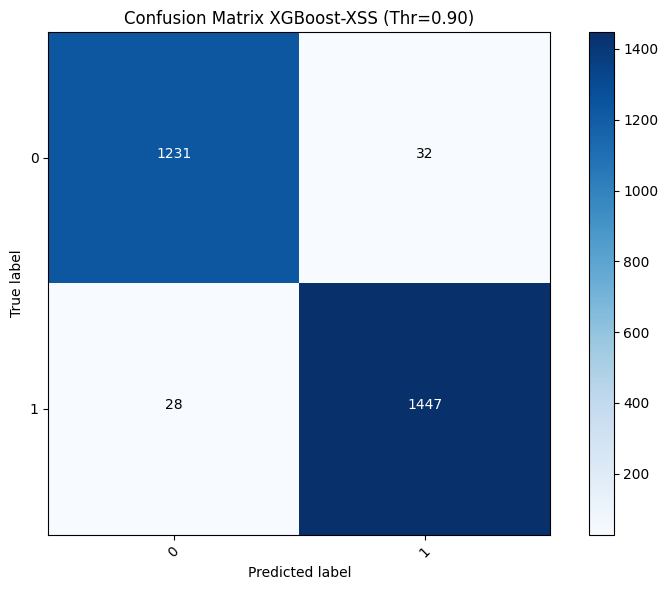

TEST: {'Model': 'XGBoost-XSS', 'Thr': 0.9, 'Precision': 0.9783637592968222, 'Recall': 0.9810169491525423, 'F1': 0.97968855788761, 'FPR': 0.025336500395882817, 'FNR': 0.018983050847457626}

TUNING: CatBoost (XSS)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 2 folds for each of 6 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CAT] best F1 (CV): 0.9945 in 18.9 min
[CAT] best params: {'tfidf__max_features': 15000, 'clf__learning_rate': 0.05, 'clf__l2_leaf_reg': 3, 'clf__iterations': 800, 'clf__depth': 6}


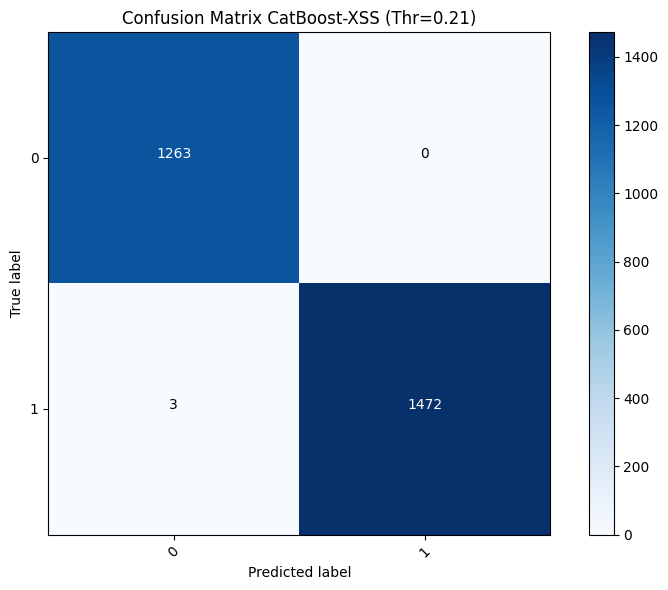

TEST: {'Model': 'CatBoost-XSS', 'Thr': 0.21000000000000002, 'Precision': 1.0, 'Recall': 0.9979661016949153, 'F1': 0.9989820156090939, 'FPR': 0.0, 'FNR': 0.002033898305084746}


,Model,Thr,Precision,Recall,F1,FPR,FNR
0,RandomForest-SQL,0.26,0.996889,0.989413,0.993137,0.001794,0.010587
1,MLP-SQL,0.16,0.997775,0.988972,0.993354,0.001281,0.011028
2,XGBoost-SQL,0.31,0.626961,0.951919,0.755999,0.329062,0.048081
3,CatBoost-SQL,0.32,0.997329,0.988090,0.992688,0.001538,0.011910


,Model,Thr,Precision,Recall,F1,FPR,FNR
0,RandomForest-XSS,0.44,0.999319,0.994576,0.996942,0.000792,0.005424
1,MLP-XSS,0.29,0.997963,0.996610,0.997286,0.002375,0.003390
2,XGBoost-XSS,0.90,0.978364,0.981017,0.979689,0.025337,0.018983
3,CatBoost-XSS,0.21,1.000000,0.997966,0.998982,0.000000,0.002034


<Figure size 1200x600 with 0 Axes>

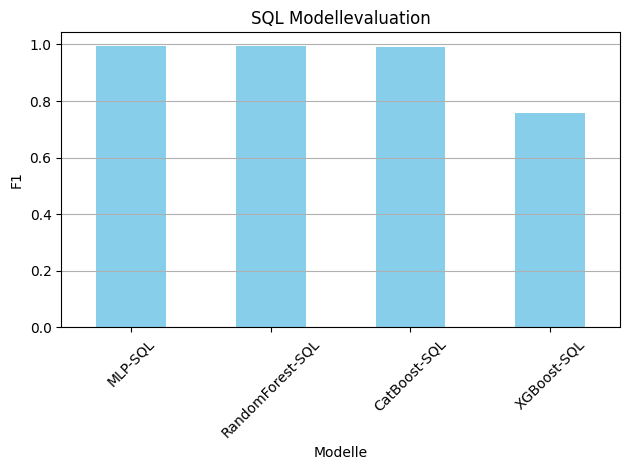

<Figure size 1200x600 with 0 Axes>

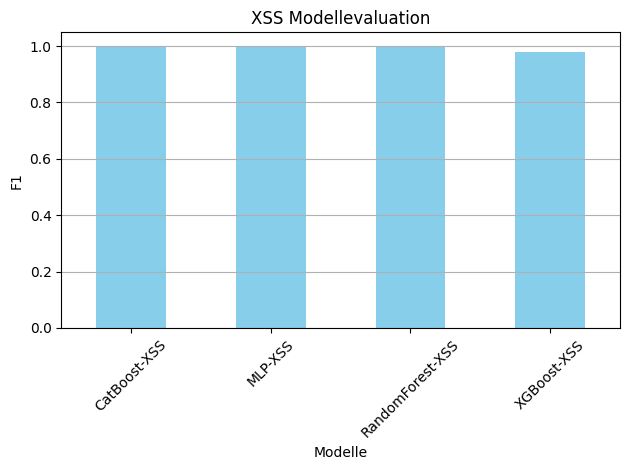

In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Gemeinsames CV-Objekt für faire Vergleiche
cv_shared = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)

# Hilfsfunktion für Hyperparameter-Suche
def make_search(estimator, param_distributions, y_train, use_halving=True, cv=None):
    if cv is None:
        cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)
    scorer = make_scorer(f1_score)
    if use_halving:
        n = len(y_train)
        min_res = max(200, int(0.15 * n))
        return HalvingRandomSearchCV(
            estimator=estimator,
            param_distributions=param_distributions,
            resource="n_samples",
            min_resources=min_res,
            max_resources="auto",
            factor=3,
            scoring=scorer,
            cv=cv,
            random_state=RANDOM_STATE,
            n_jobs=2,
            verbose=2
        )
    else:
        return RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_distributions,
            n_iter=10,
            scoring=scorer,
            cv=cv,
            random_state=RANDOM_STATE,
            n_jobs=2,
            verbose=2
        )

# Training + Suche + Refit + Threshold
def tune_one(name, X_train_txt, y_train, cv):
    if name == "RF":   pipe = pipe_rf_svd()
    elif name == "MLP": pipe = pipe_mlp_svd()
    elif name == "XGB": pipe = pipe_xgb_sparse()
    elif name == "CAT": pipe = pipe_cat_sparse()
    else: raise ValueError(name)

    # Teilmenge für HPO
    X_hpo, y_hpo = get_hpo_subset(X_train_txt, y_train, n=8000)
    space = grids(y_hpo)[name]
    search = make_search(pipe, space, y_hpo, use_halving=True, cv=cv)

    t0 = time.perf_counter()
    search.fit(X_hpo, y_hpo)
    dt = time.perf_counter() - t0
    print(f"[{name}] best F1 (CV): {search.best_score_:.4f} in {dt/60:.1f} min")
    print(f"[{name}] best params:", search.best_params_)

    best = clone(search.best_estimator_)
    best.fit(X_train_txt, y_train)
    return best, search.best_params_, search.best_score_, dt

# Threshold-Optimierung + Testauswertung
def eval_on_test(name, est, X_train_txt, y_train, X_test_txt, y_test, tune_threshold=True):
    thr = 0.5
    if tune_threshold and hasattr(est, "predict_proba"):
        X_tr2, X_val, y_tr2, y_val = train_test_split(X_train_txt, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE)
        est_for_thr = est
        est_for_thr.fit(X_tr2, y_tr2)
        p = est_for_thr.predict_proba(X_val)[:, 1]
        grid = np.linspace(0.1, 0.9, 81)
        thr = float(grid[int(np.argmax([f1_score(y_val, (p >= t).astype(int)) for t in grid]))])

    y_pred = (est.predict_proba(X_test_txt)[:,1] >= thr).astype(int) if hasattr(est, "predict_proba") else est.predict(X_test_txt)
    plot_confusion_matrix(y_test, y_pred, labels=[0, 1], title=f"Confusion Matrix {name} (Thr={thr:.2f})")
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = float(fp / (fp + tn)) if (fp + tn) else 0.0
    fnr = float(fn / (fn + tp)) if (fn + tp) else 0.0
    return dict(Model=name, Thr=thr, Precision=p, Recall=r, F1=f1, FPR=fpr, FNR=fnr)

# Ausführung mit übergebenem Split
def run_fast_from_split(X_train_txt, X_test_txt, y_train, y_test, ds_name, cv):
    results = []
    for short, label in [("RF", "RandomForest"), ("MLP", "MLP"), ("XGB", "XGBoost"), ("CAT", "CatBoost")]:
        print("\n" + "=" * 60)
        print(f"TUNING: {label} ({ds_name})")
        best_est, params, best_cv, dt = tune_one(short, X_train_txt, y_train, cv=cv)
        res = eval_on_test(f"{label}-{ds_name}", best_est, X_train_txt, y_train, X_test_txt, y_test)
        print("TEST:", res)
        results.append(res)
    return pd.DataFrame(results)

# Anwendung auf beide Datensätze
sql_res = run_fast_from_split(X_train_sql, X_test_sql, y_train_sql, y_test_sql, ds_name="SQL", cv=cv_shared)
xss_res = run_fast_from_split(X_train_xss, X_test_xss, y_train_xss, y_test_xss, ds_name="XSS", cv=cv_shared)

display(sql_res)
display(xss_res)
plot_results(sql_res, title="SQL Modellevaluation", metric="F1")
plot_results(xss_res, title="XSS Modellevaluation", metric="F1")

In [64]:
from datetime import datetime
from pathlib import Path
import pandas as pd

# Combine results and tag with dataset names
sql_res["Dataset"] = "SQL"
xss_res["Dataset"] = "XSS"

df_all = pd.concat([sql_res, xss_res], ignore_index=True)

# Anzeigen
display(df_all)

# Export to Excel
outdir = Path("reports"); outdir.mkdir(parents=True, exist_ok=True)
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
xlsx_path = outdir / f"results_tuning_{ts}.xlsx"

with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as writer:
    df_all.to_excel(writer, sheet_name="Tuning Results", index=False)

print("Ergebnisse gespeichert unter:", xlsx_path)

,Model,Thr,Precision,Recall,F1,FPR,FNR,Dataset
0,RandomForest-SQL,0.26,0.996889,0.989413,0.993137,0.001794,0.010587,SQL
1,MLP-SQL,0.16,0.997775,0.988972,0.993354,0.001281,0.011028,SQL
2,XGBoost-SQL,0.31,0.626961,0.951919,0.755999,0.329062,0.048081,SQL
3,CatBoost-SQL,0.32,0.997329,0.988090,0.992688,0.001538,0.011910,SQL
4,RandomForest-XSS,0.44,0.999319,0.994576,0.996942,0.000792,0.005424,XSS
5,MLP-XSS,0.29,0.997963,0.996610,0.997286,0.002375,0.003390,XSS
6,XGBoost-XSS,0.90,0.978364,0.981017,0.979689,0.025337,0.018983,XSS
7,CatBoost-XSS,0.21,1.000000,0.997966,0.998982,0.000000,0.002034,XSS


Ergebnisse gespeichert unter: reports\results_tuning_20250821-213023.xlsx
